In [1]:
# Date: 4/4/2018

In [2]:
import pickle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import graphlab as gl

In [38]:
os.getcwd()
os.chdir("/oasis/scratch/comet/a1singh/temp_project/bnl_dataframes/csvs")
os.getcwd()

init = True
sf   = None
itera = 0

for file in glob.glob("ee*.json.df.csv"):
    itera += 1
    #
    if init:
        #first call
        sf = gl.SFrame.read_csv(file, verbose=False)
        init = False
    else:
        sf = sf.append(gl.SFrame.read_csv(file, verbose=False))
    #
    print(itera, " File : ",file, "::  Size > ", sf.num_cols(), sf.num_rows())
    
    if itera > 50:
        break

(1, ' File : ', 'ee-test-for-ml-lammps-64+32.3755450.20.json.df.csv', '::  Size > ', 6, 150949)
(2, ' File : ', 'ee-test-for-ml-lammps-64+16.3745390.13.json.df.csv', '::  Size > ', 6, 299884)
(3, ' File : ', 'ee-test-for-ml-lammps-256+4.3755476.55.json.df.csv', '::  Size > ', 6, 492876)
(4, ' File : ', 'ee-test-for-ml-lammps-128+16.3755462.110.json.df.csv', '::  Size > ', 6, 665032)
(5, ' File : ', 'ee-test-for-ml-lammps-128+16.3755462.25.json.df.csv', '::  Size > ', 6, 835706)
(6, ' File : ', 'ee-test-for-ml-lammps-64+8.3755452.41.json.df.csv', '::  Size > ', 6, 983335)
(7, ' File : ', 'ee-test-for-ml-lammps-32+16.3755439.2.json.df.csv', '::  Size > ', 6, 1122453)
(8, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.55.json.df.csv', '::  Size > ', 6, 1293538)
(9, ' File : ', 'ee-test-for-ml-lammps-16+256.3755436.1.json.df.csv', '::  Size > ', 6, 1422371)
(10, ' File : ', 'ee-test-for-ml-lammps-16+128.3755435.0.json.df.csv', '::  Size > ', 6, 1551119)
(11, ' File : ', 'ee-test-for-ml

In [39]:
print(sf.num_cols(), sf.num_rows())

(6, 8304477)


In [40]:
sf.head(1)

X1,kl,time_by_lasttime,time_diff,node_id,thread_id
0,.TAUapplication:MPI_Init() ...,1.81236905634e-05,55486.0,20,0


In [42]:
import graphlab.aggregate as agg
ngram_count = sf.groupby(key_columns='kl', operations={'numberofcalls': agg.COUNT()})

In [43]:
ngram_count = ngram_count.sort('numberofcalls', ascending = False)
ngram_count.print_rows(max_column_width=70)

+-----------------------------------------------------------------------+---------------+
|                                   kl                                  | numberofcalls |
+-----------------------------------------------------------------------+---------------+
| voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::Verlet::run... |     719561    |
| voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::Verlet::run... |     719561    |
| voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::Verlet::run... |     719561    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::compute(in... |     717821    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::compute(in... |     717821    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::compute(in... |     717821    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::compute(in... |     370800    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::compute(in... |     370800    |
| voidLAMM

In [45]:
# Define max and min threshold
min = 500000
max = 10*min #float("inf")

subset = ngram_count[(ngram_count['numberofcalls'] > min) & (ngram_count['numberofcalls'] < max)]
freq   = subset.sample(0.1)

mul=5
while (len(freq) < 1 and mul<1):
    freq   = subset.sample(0.05*mul)
    mul *= 5
    
freq.print_rows(max_column_width=70)

+-----------------------------------------------------------------------+---------------+
|                                   kl                                  | numberofcalls |
+-----------------------------------------------------------------------+---------------+
| voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::Verlet::run... |     719561    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::compute(in... |     717821    |
+-----------------------------------------------------------------------+---------------+
[2 rows x 2 columns]



In [51]:
def perform_bayesiancp(sf, thetitle, frac):
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(14.5, 10.5)
    
    #Prune extreme outliers
    prune   = 100000
    howmany = 1
    
    while (len(sf[sf['time_diff']>prune]) > 10):
        prune   += 50000
        howmany += 1
        if(howmany > 100):
            print('Break')
            break
    
    sf = sf[sf['time_diff']<prune]
    
    # sort by time
    sf = sf.sort('time_by_lasttime', ascending = True)
    #print('Checkpoint 1 Sorted')
    
    model = gl.anomaly_detection.bayesian_changepoints.create(sf, lag=2,   feature='time_diff')
    
    #model['scores'].print_rows(max_column_width=100)
    
    scores = model['scores']['changepoint_score']
    
    #print('Checkpoint 2')
    
    thresh = 0.1
    # Select the threshold value
    howmany = 1
    while (len(scores[scores>thresh]) > frac*len(scores) and thresh<=.99):
        thresh  += .001
        howmany += 1
    
    print(thresh, len(scores[scores>thresh]))
    
    plt.title("Bayesian Changepoints; function: " + str(thetitle))
    
    # Method 1
    #print('Checkpoint 3')
    df_outliers   = model['scores'][model['scores']['changepoint_score'] > thresh]
    time_outliers = sf[model['scores']['changepoint_score'] > thresh]['time_by_lasttime']
    
    #print('Checkpoint 4')
    df_normals   = model['scores'][model['scores']['changepoint_score'] <= thresh]
    time_normals = sf[model['scores']['changepoint_score'] <= thresh]['time_by_lasttime']
    
    # Plot
    #print('Checkpoint 5')
    g = plt.scatter(time_normals ,  df_normals['time_diff'], c='green', s=65, edgecolor='k')
    h = plt.scatter(time_outliers, df_outliers['time_diff'], c='red', s=65, edgecolor='k')
    
    # Adjust Plot
    minx=sf['time_by_lasttime'].min()
    maxx=sf['time_by_lasttime'].max()
    miny=sf['time_diff'].min()
    maxy=sf['time_diff'].max()
    
    plt.axis('tight')
    plt.xlim((minx, maxx))
    plt.ylim((miny, maxy))
    plt.legend([g, h],["Normal","Outliers"],loc="upper right")
    plt.show()
    #matplotlib.pyplot.draw() 

(0.9900000000000008, 4380)


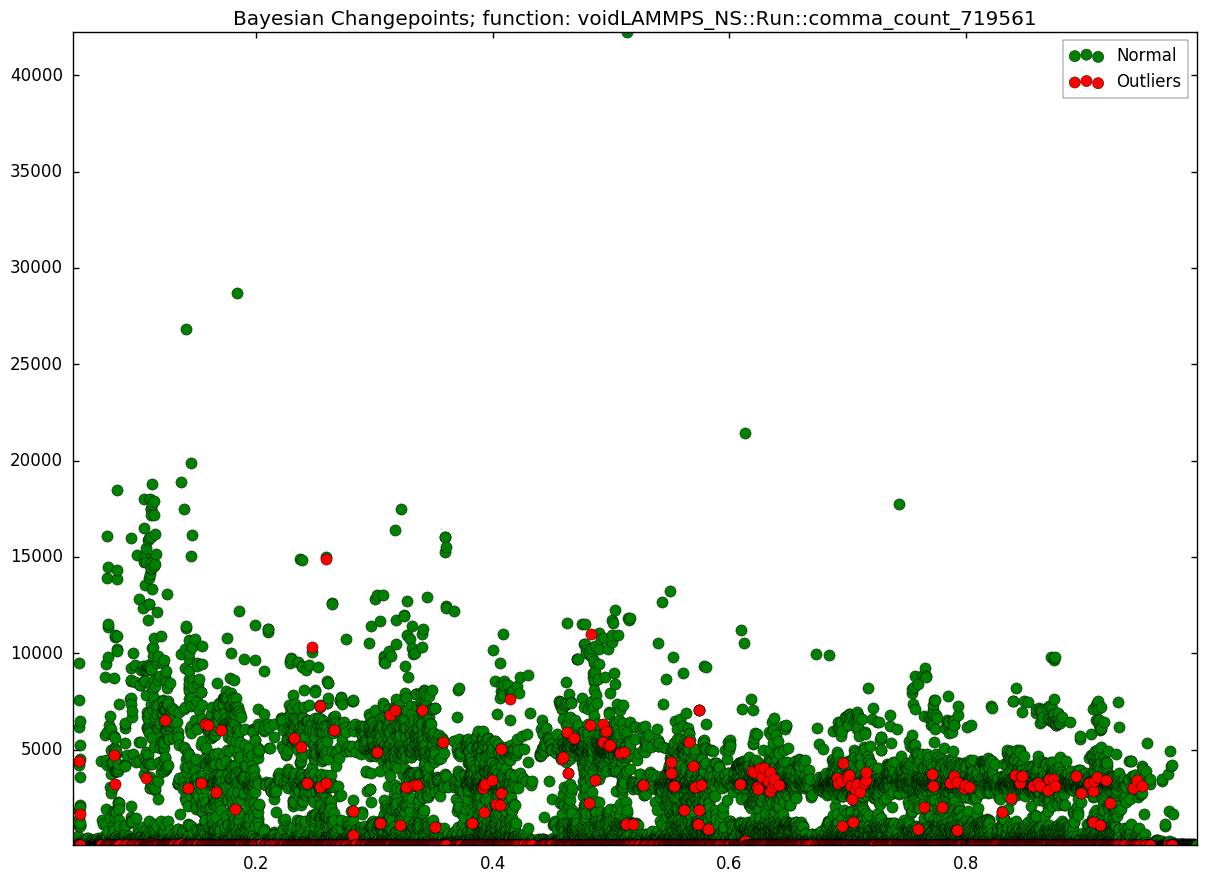

(0.9780000000000008, 578)


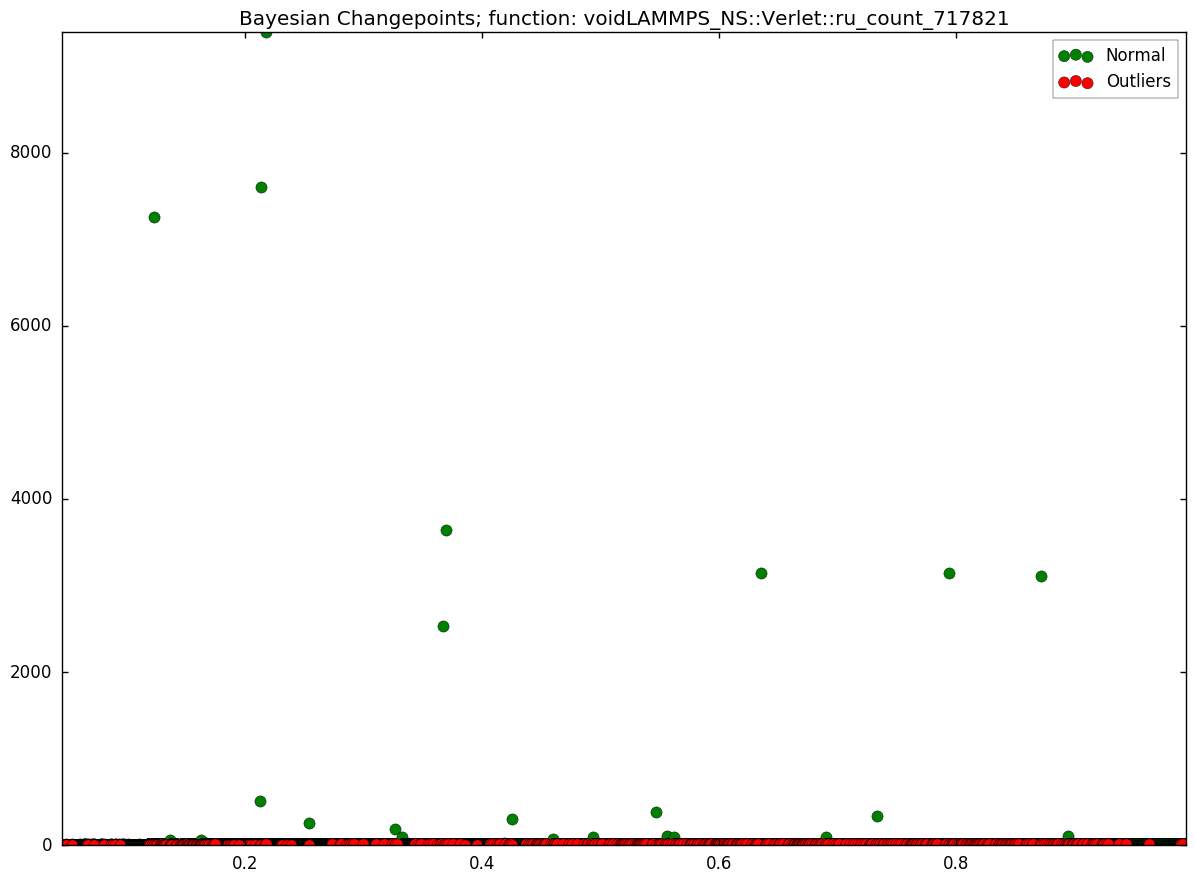

In [52]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

for i in range(len(freq)):
    pick_func = freq[i]['kl']
    count     = freq[i]['numberofcalls']
    lbl       = str(pick_func)[:25] +'_count_'+ str(count)
    
    perform_bayesiancp(sf[sf['kl'] == pick_func], lbl, 0.001)

In [ ]:
#################################################################
#################################################################
#################################################################
#################################################################
#################################################################